## Import library

In [20]:
import os
import subprocess
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
n_qubit = params["circuit_info"]["n_qubit"]
each_n_shot = params["circuit_info"]["each_n_shot"]
state_name = params["circuit_info"]["state_name"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
# RBM architecture parameter
n_visible_unit = params["architecture_info"]["n_visible_unit"]
n_hidden_unit = params["architecture_info"]["n_hidden_unit"] 
n_aux_unit = params["architecture_info"]["n_aux_unit"]
# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
seed = params["train_info"]["seed"]
# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]
# data path info
train_data_path = f"./data/{error_model}/error_prob_{100*error_rate}%/num_of_data_{each_n_shot}/"
ideal_state_path = f"./target_state/"

# settings
## warnings
warnings.simplefilter('ignore')

## seaborn layout
sns.set()
sns.set_style("white")

## seed
def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## caluculate ideal state

In [21]:
# calculate ideal state
is_ideal_state_file = os.path.exists(ideal_state_path)
if is_ideal_state_file:
    print("ideal state data is exsisted !")
else:
    print("caluculate ideal state data ...")
    os.makedirs(ideal_state_path, exist_ok = True)
    subprocess.run("python caluculate_ideal_state.py", shell=True)
    print("ideal state data is ready !")

ideal state data is exsisted !


## generate dataset

In [22]:
# generate train data
is_train_data_file = os.path.exists(train_data_path)
if is_train_data_file:
    print("train data is exsisted !")
else:
    print("generate directries & train data ...")
    os.makedirs(train_data_path, exist_ok = True)
    subprocess.run("python generate_dataset.py", shell=True)
    print("train data is ready !")

generate directries & train data ...


0it [00:00, ?it/s]
  0%|          | 2/1000 [00:00<00:52, 19.04it/s]

measurement pattern 0 : ('X', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:36<00:00, 27.53it/s][A
1it [00:36, 36.33s/it]
  0%|          | 2/1000 [00:00<00:50, 19.87it/s]

measurement pattern 1 : ('X', 'X', 'X', 'Y')



100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s][A
2it [01:09, 34.62s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 2 : ('X', 'X', 'X', 'Z')



100%|██████████| 1000/1000 [00:31<00:00, 31.50it/s]
3it [01:41, 33.31s/it]
  0%|          | 4/1000 [00:00<00:31, 31.46it/s]

measurement pattern 3 : ('X', 'X', 'Y', 'X')



100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s][A
4it [02:14, 33.09s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 4 : ('X', 'X', 'Y', 'Y')



100%|██████████| 1000/1000 [00:33<00:00, 29.49it/s][A
5it [02:48, 33.38s/it]
  0%|          | 3/1000 [00:00<00:33, 29.62it/s]

measurement pattern 5 : ('X', 'X', 'Y', 'Z')



100%|██████████| 1000/1000 [00:36<00:00, 27.27it/s]
6it [03:24, 34.50s/it]
  0%|          | 3/1000 [00:00<00:33, 29.68it/s]

measurement pattern 6 : ('X', 'X', 'Z', 'X')



100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]
7it [03:58, 34.13s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 7 : ('X', 'X', 'Z', 'Y')



100%|██████████| 1000/1000 [00:33<00:00, 30.04it/s][A
8it [04:31, 33.86s/it]
  0%|          | 4/1000 [00:00<00:31, 31.91it/s]

measurement pattern 8 : ('X', 'X', 'Z', 'Z')



100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s][A
9it [05:05, 33.77s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 9 : ('X', 'Y', 'X', 'X')



100%|██████████| 1000/1000 [00:37<00:00, 26.39it/s][A
10it [05:42, 35.05s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 10 : ('X', 'Y', 'X', 'Y')



100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s][A
11it [06:18, 35.34s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]


measurement pattern 11 : ('X', 'Y', 'X', 'Z')


100%|██████████| 1000/1000 [00:34<00:00, 28.88it/s]
12it [06:53, 35.12s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 12 : ('X', 'Y', 'Y', 'X')



100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s][A
13it [07:30, 35.78s/it]
  0%|          | 3/1000 [00:00<00:37, 26.81it/s]

measurement pattern 13 : ('X', 'Y', 'Y', 'Y')



100%|██████████| 1000/1000 [00:38<00:00, 26.28it/s][A


measurement pattern 14 : ('X', 'Y', 'Y', 'Z')


14it [08:08, 36.47s/it]
100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s][A
15it [08:45, 36.39s/it]
  0%|          | 3/1000 [00:00<00:35, 28.47it/s]

measurement pattern 15 : ('X', 'Y', 'Z', 'X')



100%|██████████| 1000/1000 [00:35<00:00, 28.38it/s][A
16it [09:20, 36.04s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 16 : ('X', 'Y', 'Z', 'Y')



100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s][A
17it [09:53, 35.05s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 17 : ('X', 'Y', 'Z', 'Z')



100%|██████████| 1000/1000 [00:31<00:00, 31.41it/s][A
18it [10:24, 34.09s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 18 : ('X', 'Z', 'X', 'X')



100%|██████████| 1000/1000 [00:31<00:00, 31.47it/s][A
19it [10:56, 33.39s/it]
  0%|          | 4/1000 [00:00<00:30, 32.66it/s]

measurement pattern 19 : ('X', 'Z', 'X', 'Y')



100%|██████████| 1000/1000 [00:31<00:00, 31.85it/s][A
20it [11:28, 32.80s/it]
  0%|          | 4/1000 [00:00<00:29, 33.25it/s]

measurement pattern 20 : ('X', 'Z', 'X', 'Z')



100%|██████████| 1000/1000 [00:30<00:00, 32.46it/s]
21it [11:58, 32.20s/it]
  0%|          | 4/1000 [00:00<00:30, 32.76it/s]

measurement pattern 21 : ('X', 'Z', 'Y', 'X')



100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s]
22it [12:30, 32.08s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 22 : ('X', 'Z', 'Y', 'Y')



100%|██████████| 1000/1000 [00:32<00:00, 31.01it/s][A
23it [13:03, 32.13s/it]
  0%|          | 4/1000 [00:00<00:30, 32.58it/s]

measurement pattern 23 : ('X', 'Z', 'Y', 'Z')



100%|██████████| 1000/1000 [00:31<00:00, 31.74it/s][A
24it [13:34, 31.95s/it]
  0%|          | 4/1000 [00:00<00:29, 33.35it/s]

measurement pattern 24 : ('X', 'Z', 'Z', 'X')



100%|██████████| 1000/1000 [00:31<00:00, 31.86it/s][A
25it [14:05, 31.78s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 25 : ('X', 'Z', 'Z', 'Y')



100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s][A
26it [14:37, 31.63s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 26 : ('X', 'Z', 'Z', 'Z')



100%|██████████| 1000/1000 [00:30<00:00, 32.62it/s][A
27it [15:07, 31.34s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 27 : ('Y', 'X', 'X', 'X')



100%|██████████| 1000/1000 [00:32<00:00, 30.98it/s][A
28it [15:40, 31.62s/it]
  0%|          | 0/1000 [00:00<?, ?it/s]

measurement pattern 28 : ('Y', 'X', 'X', 'Y')


  0%|          | 1/1000 [00:00<01:06, 15.10it/s]
28it [15:40, 33.58s/it]
Traceback (most recent call last):
  File "/content/GitHub/NQS4QEM/4-qubit_GHZ/generate_dataset.py", line 597, in <module>
    main()
  File "/content/GitHub/NQS4QEM/4-qubit_GHZ/generate_dataset.py", line 591, in main
    meas_pattern_df, train_df = generate(n_qubit, state_name, each_n_shot, error_model)
  File "/content/GitHub/NQS4QEM/4-qubit_GHZ/generate_dataset.py", line 577, in generate
    label, result = pauli_measurement(n_qubit, state_name, error_model, meas_pattern)
  File "/content/GitHub/NQS4QEM/4-qubit_GHZ/generate_dataset.py", line 554, in pauli_measurement
    measurement_result_list.append(np.random.choice(["0","1"], p=[p0,p1]))
  File "mtrand.pyx", line 937, in numpy.random.mtrand.RandomState.choice
ValueError: probabilities are not non-negative


train data is ready !


## load dataset

In [7]:
meas_pattern_path = train_data_path + "/measurement_pattern.txt"
meas_label_path = train_data_path + "/measurement_label.txt"
meas_result_path = train_data_path + "/measurement_result.txt"
ideal_rho_re_path = ideal_state_path + "/rho_real.txt"
ideal_rho_im_path = ideal_state_path + "/rho_imag.txt"
meas_result, ideal_rho, meas_label, meas_pattern = data.load_data_DM(meas_result_path,
                                                                     ideal_rho_re_path,
                                                                     ideal_rho_im_path,
                                                                     meas_label_path,
                                                                     meas_pattern_path)

## build RBM architecture

In [8]:
nn_state_dm = DensityMatrix(
    num_visible = n_visible_unit, 
    num_hidden = n_hidden_unit, 
    num_aux = n_aux_unit, 
    unitary_dict = unitaries.create_dict(),
    gpu = False
)

## estimate observable expectation value

In [9]:
class GeneralPauliDistill(ObservableBase):
    def __init__(self, pauli_dict: dict, m: int) -> None:
        self.name = "distilled_pauli"
        self.symbol = "distilled_general_pauli"
        self.pauli_dict = pauli_dict
        self.num_copy = m
        
    def apply(self, nn_state, samples):
        """
        This function calcualte <x1 x2 ... xm | rho^{\otimes m} O | xm x1 x2 ... xm-1> / <x1 x2 ... xm | rho^{\otimes m} | x1 x2 ... xm>
        where O acts only on the first register.
        """
        
        # [num_sample, num_visible_node]
        # samples = [s1, s2, s3 ... sN]
        #  where num_sample = N, and si is num_visible_node-bits
        samples = samples.to(device=nn_state.device)
        
        num_sample, num_visible_node = samples.shape
        
        # [num_sample, num_visible_node * num_copy]
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        #  each row is num_copy*num_visible_node bits the above example is for num_copy=3
        samples_array = []
        for copy_index in range(self.num_copy):
            rolled_samples = torch.roll(samples, shifts=copy_index, dims=0)
            samples_array.append(rolled_samples)
        samples_array = torch.hstack(samples_array)
        assert(samples_array.shape[0] == num_sample)
        assert(samples_array.shape[1] == num_visible_node * self.num_copy)
        
        # roll second dim of [num_sample, num_visible_node * num_copy] by num_visible_node
        # swapped_samples_array = [[sN-1 s1 sN], [sN s2 s1], [s1 s3 s2],.. [sN-2 sN sN-1]]
        swapped_samples_array = torch.roll(samples_array, shifts = num_visible_node, dims=1)

        # pick copy of first block
        #  first_block_sample = [sN-1, sN, s1, s2, ... sN-2]
        first_block_sample = swapped_samples_array[:, :num_visible_node].clone()

        # calculate coefficient for first block [num_samples, 0:num_visible_node]
        total_prod = cplx.make_complex(torch.ones_like(samples[:,0]), torch.zeros_like(samples[:,0]))
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            coeff = to_pm1(first_block_sample[:, index])
            if pauli == "Z":
                coeff = cplx.make_complex(coeff, torch.zeros_like(coeff))
                total_prod = cplx.elementwise_mult(coeff, total_prod)
            elif pauli == "Y":
                coeff = cplx.make_complex(torch.zeros_like(coeff), coeff)
                total_prod = cplx.elementwise_mult(coeff, total_prod)
        
        # flip samples for for first block [num_samples, 0:num_visible_node]
        # first_block_sample -> [OsN-1, OsN, Os1, Os2, ... OsN-2]
        #  where Osi is bit array after Pauli bit-flips 
        for index, pauli in self.pauli_dict.items():
            assert(index < num_visible_node)
            if pauli in ["X", "Y"]:
                first_block_sample = flip_spin(index, first_block_sample)


        # store flipped first block
        swapped_samples_array[:, :num_visible_node] = first_block_sample

        # calculate product of coefficients
        # samples_array = [[s1 sN sN-1], [s2 s1 sN], [s3 s2 s1],.. [sN sN-1 sN-2]]
        # swapped_samples_array = [[OsN-1 s1 sN], [OsN s2 s1], [Os1 s3 s2],.. [OsN-2 sN sN-1]]
        """
        total_prod = [
            <s1 sN sN-1 | rho^{\otimes 3} | OsN-1 s1 sN> / <s1 sN sN-1 | rho^{\otimes 3} | s1 sN sN-1> , 
            <s2 s1 sN   | rho^{\otimes 3} | OsN s2 s1>   / <s2 s1 sN   | rho^{\otimes 3} | s2 s1 sN> , 
            <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1> , 

        e.g. 
        <s3 s2 s1   | rho^{\otimes 3} | Os1 s3 s2>   / <s3 s2 s1   | rho^{\otimes 3} | s3 s2 s1>
         = <s3 | rho | Os1> <s2 | rho | s3> < s1| rho | s2> / (<s3 | rho | s3> <s2 | rho | s2> < s1| rho | s1>)
         =  (<s3 | rho | Os1> / <s3 | rho | s3>)
          * (<s2 | rho | s3> / <s2 | rho | s2> )
          * (< s1| rho | s2> / < s1| rho | s1>)
         
        importance_sampling_numerator(s3, Os1)  provides <s3 | rho | Os1>
        importance_sampling_denominator(s3)     provides <s3 | rho | s3>
        """
        for copy_index in range(self.num_copy):
            st = copy_index * samples.shape[1]
            en = (copy_index+1) * samples.shape[1]
            # numerator is []
            numerator = nn_state.importance_sampling_numerator(swapped_samples_array[:, st:en], samples_array[:, st:en])
            denominator = nn_state.importance_sampling_denominator(samples_array[:, st:en])
            values = cplx.elementwise_division(numerator, denominator)
            total_prod = cplx.elementwise_mult(total_prod, values)

        value = cplx.real(total_prod)
        return value

def calculate_distilled_expectation_value(pauli_dict: dict, num_samples: int, num_copies: int):
    obs_num = GeneralPauliDistill(pauli_dict, num_copies)
    obs_div = GeneralPauliDistill({}, num_copies)
    num_stat = obs_num.statistics(nn_state_dm, num_samples=num_samples)
    div_stat = obs_div.statistics(nn_state_dm, num_samples=num_samples)

    from uncertainties import ufloat
    num = ufloat(num_stat["mean"], num_stat["std_error"])
    div = ufloat(div_stat["mean"], div_stat["std_error"])
    val = num/div
    result_dict = {"mean": val.n , "std_error": val.s, "num_samples": num_samples, "num_copies": num_copies}
    return result_dict

def get_density_matrix(nn_state):
    space = nn_state.generate_hilbert_space()
    Z = nn_state.normalization(space)
    tensor = nn_state.rho(space, space)/Z
    matrix = cplx.numpy(tensor)
    return matrix

def get_max_eigvec(matrix):
    e_val, e_vec = np.linalg.eigh(matrix)
    me_val = e_val[-1]
    me_vec = e_vec[:,-1]
    return me_vec

def get_eigvec(nn_state, obs, space, **kwargs):
    dm = get_density_matrix(nn_state)
    ev = get_max_eigvec(dm)
    ev = np.atleast_2d(ev)
    val = ev@obs@ev.T.conj()
    val = val[0,0].real
    return val

def observable_XXXX():
    target_list = [0, 1, 2, 3]
    pauli_index = [1, 1, 1, 1] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = X_1 X_2 X_3 X_4
    return gate.get_matrix()

def observable_ZZZZ():
    target_list = [0, 1, 2, 3]
    pauli_index = [3, 3, 3, 3] # 1:X , 2:Y, 3:Z
    gate = Pauli(target_list, pauli_index) # = Z_1 Z_2 Z_3 Z_4
    return gate.get_matrix()

def observable_XXXX_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "X", 2: "X", 3:"X"}, n_sampling, n_copy)
    return obs_stat["mean"]

def observable_XXXX_var(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "X", 2: "X", 3:"X"}, n_sampling, n_copy)
    return obs_stat["std_error"]**2


def observable_ZZZZ_ev(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "Z", 2: "Z", 3:"Z"}, n_sampling, n_copy)
    return obs_stat["mean"]

def observable_ZZZZ_var(nn_state, **kwargs):
    obs_stat = calculate_distilled_expectation_value({0: "X", 1: "Z", 2: "Z", 3:"Z"}, n_sampling, n_copy)
    return obs_stat["std_error"]

## callback setting 

In [11]:
def create_callback_dm(nn_state):
    metric_dict = {
        "Fidelity": ts.fidelity,
        "KL_Divergence": ts.KL,
        "Observable_XXXX_ev": observable_XXXX_ev,
        "Observable_XXXX_var": observable_XXXX_var
        "Observable_ZZZZ_ev": observable_ZZZZ_ev,
        "Observable_ZZZZ_var": observable_ZZZZ_var,
    }

    space = nn_state.generate_hilbert_space()
    callbacks = [
        MetricEvaluator(
            period,
            metric_dict,
            target = ideal_rho,
            bases = meas_pattern,
            verbose = True,
            space = space,
        )
    ]
    return callbacks

callbacks = create_callback_dm(nn_state_dm)

## train

In [12]:
nn_state_dm.fit(
    data = meas_result,
    input_bases = meas_label,
    epochs = epoch,
    pos_batch_size = pbs,
    neg_batch_size = nbs,
    lr = lr,
    k = n_gibbs_step,
    bases = meas_pattern,
    callbacks = callbacks,
    time = True,
    optimizer = torch.optim.Adadelta,
    scheduler = torch.optim.lr_scheduler.StepLR,
    scheduler_args = {"step_size": lr_drop_epoch, "gamma": lr_drop_factor},
)

Epoch: 1	Fidelity = 0.369828	KL_Divergence = 0.427393	Observable_XXXX_ev = -0.001147	Observable_ZZZZ_ev = -0.165821
Epoch: 2	Fidelity = 0.369514	KL_Divergence = 0.317854	Observable_XXXX_ev = 0.009828	Observable_ZZZZ_ev = -0.207758
Epoch: 3	Fidelity = 0.429410	KL_Divergence = 0.126458	Observable_XXXX_ev = 0.007945	Observable_ZZZZ_ev = -0.051970
Epoch: 4	Fidelity = 0.453334	KL_Divergence = 0.114492	Observable_XXXX_ev = 0.004615	Observable_ZZZZ_ev = -0.034090
Epoch: 5	Fidelity = 0.443506	KL_Divergence = 0.153446	Observable_XXXX_ev = 0.007250	Observable_ZZZZ_ev = -0.067615
Epoch: 6	Fidelity = 0.450541	KL_Divergence = 0.219872	Observable_XXXX_ev = 0.005107	Observable_ZZZZ_ev = -0.051389
Epoch: 7	Fidelity = 0.452605	KL_Divergence = 0.195738	Observable_XXXX_ev = 0.005542	Observable_ZZZZ_ev = -0.025799
Epoch: 8	Fidelity = 0.452515	KL_Divergence = 0.287595	Observable_XXXX_ev = 0.003988	Observable_ZZZZ_ev = -0.052375
Epoch: 9	Fidelity = 0.456938	KL_Divergence = 0.094558	Observable_XXXX_ev = 0.01

Text(0.5, 0, 'Epoch')

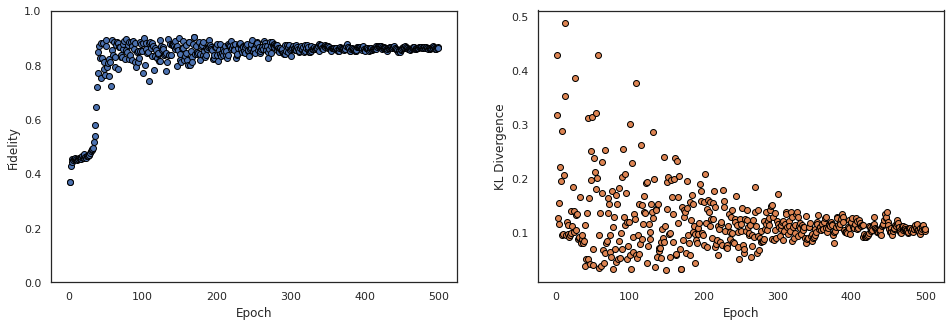

In [13]:
fidelities = callbacks[0]["Fidelity"]
KLs = callbacks[0]["KL_Divergence"]
epoch_range = np.arange(period, epoch + 1, period)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
ax = axs[0]
ax.plot(epoch_range, fidelities, "o", color = "C0", markeredgecolor = "black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim(0.00, 1.00)

ax = axs[1]
ax.plot(epoch_range, KLs, "o", color = "C1", markeredgecolor = "black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

## save model & train log

In [ ]:
# save model
nn_state_dm.save("./exp001/model.pt")
# save train log
train_log_df = pd.DataFrame()
train_log_df["epoch"] = np.arange(period, epoch+1, period)
train_log_df["Fidelity"] = callbacks[0]["Fidelity"]
train_log_df["KL_Divergence"] = callbacks[0]["KL_Divergence"]
train_log_df["Observable_XXXX_ev"] = callbacks[0]["Observable_XXXX_ev"]
train_log_df["Observable_ZZZZ_ev"] = callbacks[0]["Observable_ZZZZ_ev"]
train_log_df.to_csv("./exp001/train_log.csv", index=False)